In [15]:
!pip install -U tensorflow
!pip install -U sklearn

     |████████████████████████████████| 394.3MB 42kB/s 
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [16]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
PATH = "/content/gdrive/My Drive/Facultate/SII"

Mounted at /content/gdrive


In [17]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud
import seaborn as sns
import itertools
import json
import gensim
from sklearn.metrics import classification_report, accuracy_score


tf.config.list_physical_devices('GPU')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[]

In [18]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [19]:
train = pd.read_json(os.path.join(PATH, "referate-train.json"))
validate = pd.read_json(os.path.join(PATH, "referate-dev.json"))
test = pd.read_json(os.path.join(PATH, "referate-test.json"))

In [ ]:
# train = shuffle(train)
# train = train.reset_index(drop=True)

# test = shuffle(test)
# test = test.reset_index(drop=True)

# validate = shuffle(validate)
# validate = validate.reset_index(drop=True)

In [20]:
#Converting train data to gensim format, remove punctuation and stopwords
X_test = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in test["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X_test.append(tmp)

In [21]:
y_train = train["grade"].values
#Converting train data to gensim format, remove punctuation and stopwords
X_train = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in train["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X_train.append(tmp)


In [22]:
y_validate = validate["grade"].values
#Converting train data to gensim format, remove punctuation and stopwords
X_validate = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in validate["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X_validate.append(tmp)


In [23]:
df = pd.concat([train, test, validate])

In [24]:
#Converting train data to gensim format, remove punctuation and stopwords
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)


In [25]:
# Dimension of generated vectors
EMBEDDING_DIM = 10
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [26]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
maxlen = 1000 
vocab_size = len(tokenizer.word_index) + 1
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [27]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)


In [28]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_validate = pad_sequences(X_validate, maxlen=maxlen)


In [35]:
#Defining Neural Network
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
model.add(LSTM(64, recurrent_dropout=0.4))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])


In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=50, callbacks=[callback])

Epoch 1/50
148/148 [==============================] - 1453s 10s/step - loss: 5.1692 - mae: 1.4902 - root_mean_squared_error: 2.0626 - val_loss: 1.0403 - val_mae: 0.7785 - val_root_mean_squared_error: 1.0200
Epoch 2/50
148/148 [==============================] - 1449s 10s/step - loss: 1.1533 - mae: 0.8358 - root_mean_squared_error: 1.0735 - val_loss: 1.0572 - val_mae: 0.8412 - val_root_mean_squared_error: 1.0282
Epoch 3/50
148/148 [==============================] - 1454s 10s/step - loss: 1.1364 - mae: 0.8273 - root_mean_squared_error: 1.0656 - val_loss: 1.0194 - val_mae: 0.7928 - val_root_mean_squared_error: 1.0097
Epoch 4/50
148/148 [==============================] - 1459s 10s/step - loss: 1.1663 - mae: 0.8426 - root_mean_squared_error: 1.0797 - val_loss: 1.0512 - val_mae: 0.7781 - val_root_mean_squared_error: 1.0253
Epoch 5/50
148/148 [==============================] - 1450s 10s/step - loss: 1.2058 - mae: 0.8492 - root_mean_squared_error: 1.0978 - val_loss: 1.0116 - val_mae: 0.7972 - v

In [34]:
model.save(os.path.join(PATH, "model_without_drop.h5"))

In [ ]:
# model = tf.keras.models.load_model(os.path.join(PATH, "model.h5"))
# model = tf.keras.models.load_model(os.path.join(PATH, "model2.h5"))


In [37]:
print(history.history['loss'])
print("----------------")
print(history.history['val_loss'])
print("----------------")

print(history.history['mae'])
print("----------------")

print(history.history['val_mae'])
print("----------------")

print(history.history['root_mean_squared_error'])
print("----------------")

print(history.history['val_root_mean_squared_error'])


[2.094651222229004, 1.21513831615448, 1.1897763013839722, 1.1688389778137207, 1.1716662645339966, 1.1680099964141846, 1.2026857137680054, 1.1722157001495361, 1.1542354822158813, 1.158101201057434]
----------------
[1.040299415588379, 1.0571644306182861, 1.0193963050842285, 1.0511974096298218, 1.0115854740142822, 1.2433096170425415, 1.0109480619430542, 1.0201784372329712, 1.015671968460083, 1.0318328142166138]
----------------
[1.0140204429626465, 0.854698896408081, 0.8430582284927368, 0.8381187915802002, 0.8381614089012146, 0.8374638557434082, 0.847831130027771, 0.8396908044815063, 0.8306443691253662, 0.832072377204895]
----------------
[0.7784740328788757, 0.8412215709686279, 0.792797863483429, 0.7780511379241943, 0.7972199320793152, 0.8305161595344543, 0.8064616918563843, 0.8054963946342468, 0.8010753393173218, 0.8087064623832703]
----------------
[1.4472910165786743, 1.1023330688476562, 1.0907686948776245, 1.0811285972595215, 1.0824353694915771, 1.0807451009750366, 1.096670269966125

([<matplotlib.axis.XTick at 0x7f6db4240940>,
 <a list of 13 Text major ticklabel objects>)

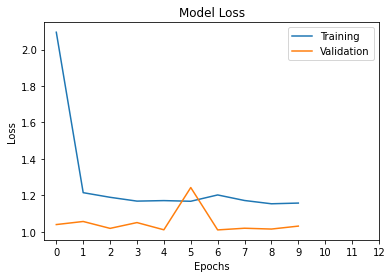

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])

## FARA DROP

In [61]:
model = tf.keras.models.load_model(os.path.join(PATH, "model_without_drop.h5"))

In [62]:
y_test = model.predict(X_test)

In [63]:
test['grade'] = y_test 

In [64]:
test.to_json(os.path.join(PATH, "rezultate_without_drop.json"), orient='records')

In [65]:
y_validate_2 = model.predict(X_validate)

In [66]:
validate['grade'] = y_validate_2

In [67]:
validate.to_json(os.path.join(PATH, "rezultate_validate_fara_drop.json"), orient='records')

## CU DROP

In [68]:
model = tf.keras.models.load_model(os.path.join(PATH, "model.h5"))

In [69]:
y_test = model.predict(X_test)

In [70]:
test['grade'] = y_test 

In [71]:
test.to_json(os.path.join(PATH, "rezultate_cu_drop.json"), orient='records')

In [72]:
y_validate = model.predict(X_validate)

In [73]:
validate['grade'] = y_validate 

In [74]:
validate.to_json(os.path.join(PATH, "rezultate_validate_cu_drop.json"), orient='records')